In [1]:
!pip install git+https://github.com/JoaquinAmatRodrigo/skforecast@v0.1.8.1

  Cloning https://github.com/JoaquinAmatRodrigo/skforecast (to revision v0.1.8.1) to /tmp/pip-req-build-k06mw0_t
  Running command git clone -q https://github.com/JoaquinAmatRodrigo/skforecast /tmp/pip-req-build-k06mw0_t
  Running command git checkout -q e9f125fec47e13a6ba768bf9e5c362815e84d767


In [2]:
!pip install -U scikit-learn

In [3]:
!pip install --upgrade matplotlib

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
stocks = pd.read_csv('bitcoinStocks.csv')

In [6]:
stocks.head()

,date,open,high,low,close,volume,go_up
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800.0,False
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200.0,False
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700.0,False
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600.0,True
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100.0,False


# Feature selection

In [7]:
stocks_close = stocks.close
stocks_close = stocks_close.to_frame()
stocks_close.head()

,close
0,457.334015
1,424.440002
2,394.795990
3,408.903992
4,398.821014


# Train / Test

In [8]:
test = 0.1
train_ts = stocks_close[:int(-len(stocks_close)*test)]
train_ts.shape

(2242, 1)

In [9]:
test_ts = stocks_close[int(-len(stocks_close)*test):]
test_ts.shape

(249, 1)

In [31]:
# from sklearn.metrics import mean_absolute_percentage_error
from AutoRegForecaster import AutoRegForecaster
from VanillaLSTM import VanillaLSTM
from StackedLSTM import StackedLSTM
from BidirectionalLSTM import BidirectionalLSTM

epochs = 200
batch_size = 32
n_steps = 7
n_outputs = 1

model = VanillaLSTM(n_neurons=10, n_steps=n_steps, n_outputs=n_outputs)

history = model.train(train_ts, epochs=50, batch_size=batch_size)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 10)                480       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
63/63 [==============================] - 3s 14ms/step - loss: 0.0531 - accuracy: 1.9249e-04 - val_loss: 0.0624 - val_accuracy: 0.0000e+00
Epoch 2/50
63/63 [==============================] - 0s 5ms/step - loss: 0.0173 - accuracy: 0.0020 - val_loss: 0.0058 - val_accuracy: 0.0000e+00
Epoch 3/50
63/63 [==============================] - 0s 4ms/step - loss: 0.0023 - accuracy: 7.6478e-04 - val_loss: 6.4460e-04 - val_accuracy: 0.0000e+00
Epoch 4/50
63/63 [==============================] - 0s 5ms/step - l

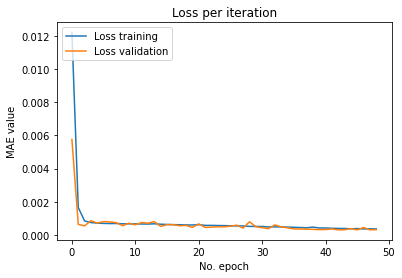

In [40]:
# Plot history: MAE
plt.plot(history['loss'][1:], label='Loss training')
plt.plot(history['val_loss'][1:], label='Loss validation')

plt.title('Loss per iteration')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")

# Predict

In [12]:
train_ts.shape

(2242, 1)

(249, 1)


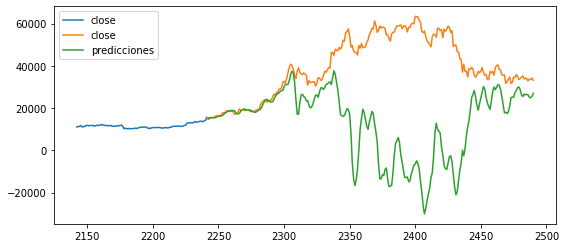

In [41]:
test = pd.concat([train_ts[-n_steps:], test_ts]) 
predictions = model.predict(test)
print(predictions.shape)
predictions = predictions.reshape(predictions.shape[0])
predictions_ts = pd.Series(data=predictions, index=test_ts.index)

train_plot_df = train_ts[-100:]
# Plot
fig, ax = plt.subplots(figsize=(9, 4))
train_plot_df.plot(ax=ax, label='train')
test_ts.plot(ax=ax, label='test')
predictions_ts.plot(ax=ax, label='predicciones')
ax.legend();

# Evaluate

In [14]:
import seaborn as sns
from sklearn.metrics import mean_squared_error

def build_prediction_dataframe(training_ts, predictions_ts):
  last_training_predictions = [training_ts.tail(1), predictions_ts]
  last_training_predictions_ts = pd.concat(last_training_predictions)
  last_training_predictions_df = last_training_predictions_ts.reset_index()
  print(last_training_predictions_df.head())
  last_training_predictions_df['positive_delta'] = last_training_predictions_df.apply(lambda row: row.name > 0 and last_training_predictions_df.loc[row.name-1, :]['close'] < row['close'], axis=1)
  print(last_training_predictions_df.head())
  predictions_df = last_training_predictions_df.iloc[1: , :][['positive_delta']]
  return predictions_df

def add_row_confusion_matrix(list_of_cm, df_row):
  row = 0
  column = 0
  if df_row.positive_delta_predict:
    column = 1
  if df_row.positive_delta_actual:
    row = 1
  list_of_cm[df_row.name-1][row, column] += 1
  return list_of_cm

def evaluate(model, ts, n_evaluations=10, n_test=3, n_steps=1, n_epochs=100, batch_size=16):
  total_hits = 0
  total_tries = 0
  confusion_matrix = [np.zeros((2,2)), np.zeros((2,2)), np.zeros((2,2))]
  for i in reversed(range(1, n_evaluations + 1)):
    print('Iteration', n_evaluations - i, 'started')
    train_evaluate = ts[:-n_test*i]
    test_evaluate = ts[-n_test*i:]
    test_evaluate = test_evaluate[:n_test]
    last_training = train_evaluate[-n_steps:]
    model.train(train_evaluate, n_epochs, batch_size)
    predictions = model.predict(last_training)
    model.re
    predictions = predictions.reshape(predictions.shape[1])
    predictions_ts = pd.DataFrame({'close': predictions}, test_evaluate.index)

    predictions_df = build_prediction_dataframe(train_evaluate, predictions_ts)
    predictions_df.rename(columns={'positive_delta': 'positive_delta_predict'}, inplace=True)

    test_df = build_prediction_dataframe(train_evaluate, test_evaluate)
    test_df.rename(columns={'positive_delta': 'positive_delta_actual'}, inplace=True)

    predictions_and_test = pd.concat([test_df, predictions_df], axis=1)
    predictions_and_test['equal'] = predictions_and_test.apply(lambda row: row['positive_delta_actual'] == row['positive_delta_predict'], axis=1)
    predictions_and_test.apply(lambda row: add_row_confusion_matrix(confusion_matrix, row), axis=1)

    hits = predictions_and_test['equal'].sum()
    print('Accuracy: {}/{}'.format(hits, predictions_and_test.shape[0]))
    total_hits += hits
    total_tries += predictions_and_test.shape[0]
  print('Total hits: {}. Total tries: {}. Accuracy: {:0.2f}'.format(total_hits, total_tries, total_hits / total_tries))
  
  return confusion_matrix

In [34]:
iter_evaluation = 10
n_test_iteration = 3
epochs = 50
n_steps = 7
n_outputs = 3

model_evaluate = VanillaLSTM(n_neurons=50, n_steps=n_steps, n_outputs=n_outputs)
confusion_matrix = evaluate(model_evaluate,ts=stocks_close, n_evaluations=iter_evaluation, n_test=n_test_iteration, n_steps=n_steps, n_epochs=epochs)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 50)                10400     
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 153       
Total params: 10,553
Trainable params: 10,553
Non-trainable params: 0
_________________________________________________________________
None
Iteration 0 started
Epoch 1/50
138/138 [==============================] - 3s 10ms/step - loss: 0.0026 - accuracy: 0.3937 - val_loss: 0.0084 - val_accuracy: 0.3943
Epoch 2/50
138/138 [==============================] - 1s 5ms/step - loss: 7.1621e-05 - accuracy: 0.3590 - val_loss: 0.0063 - val_accuracy: 0.3740
Epoch 3/50
138/138 [==============================] - 1s 5ms/step - loss: 7.9306e-05 - accuracy: 0.3320 - val_loss: 0.0062 - val_accuracy: 0.3984
Epoch 4/50
138/138 [==============================]

In [37]:
def plot_confusion_matrix(confusion_matrix):
  fig, axs = plt.subplots(2, 2)
  fig.supxlabel('Predicted')
  fig.supylabel('Actual')
  for i in range(0, len(confusion_matrix)):
    ax = axs[int(i/2), i%2]
    ax.title.set_text('Index {}'.format(i+1))
    sns.heatmap(data=confusion_matrix[i], annot=True, cbar=False, ax=ax)
  sum_cm = sum(confusion_matrix)
  axs[1,1].title.set_text('Total')
  sns.heatmap(data=sum_cm, annot=True, cbar=False, ax=axs[1,1])

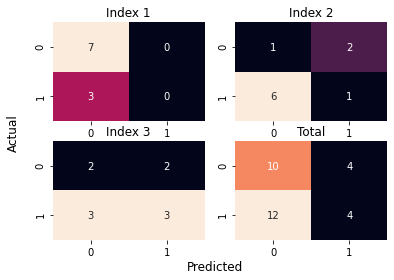

In [39]:
plot_confusion_matrix(confusion_matrix)